In [1]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras import layers, Model, regularizers, optimizers, constraints
# from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os
from tqdm import tqdm_notebook
import io
import unidecode
import pandas as pd
from classifiers.deep_learning.Attention import Attention
import matplotlib.pylab as plt
%matplotlib inline

In [19]:
#with open('vocabulary_emb.pk', 'rb') as handle:
my_voc = pickle.load( open("vocabulary_emb.pk", "rb"))

In [ ]:
#### TON EXW KANEI SAVE
embedding_matrix = np.zeros((len(my_voc)+1, 300))     ##arxikopoiw enan embedding_matrix megethous (mhkos voc) x (300)
with io.open('cc.de.300.vec', encoding='utf-8') as embedding_file:
    for i, l in enumerate(embedding_file):
        values = l.rstrip().rsplit(' ')     #removing whitespaces kai split
        if i > 0:                           #h prwti thesi einai gia ton pad xaraktira ara tin prospernaw
            word = values[0]                #sto values[0] einai i leksi kai sto values[1:] einai to duanisma tis
            if word in my_voc:              #pairnw ta embeddings twn leksewn pou briskontai mesa sto my_voc
                coefs = np.asarray(values[1:], dtype='float32')       #pernw tis times apo tin thesi 1 kai meta
                embedding_matrix[my_voc[word]] = coefs
embedding_matrix.shape #ara exw sunolo 43655 lekseis gia tis opoies phra ta embeddings

In [5]:
type(embedding_matrix)

numpy.ndarray

In [20]:
# my_voc = pickle.load( open("vocabulary_emb2.pk", "rb"))
# embedding_matrix = np.zeros((len(my_voc)+1, 300))
# count = 0
# with io.open('glove.txt', encoding='utf-8') as embedding_file:
#     for word, l in enumerate(embedding_file):
#         values = l.rstrip().rsplit(' ')
#         word = values[0]
#         if word in my_voc:
#             count += 1
#             coefs = np.asarray(values[1:], dtype='float32')       #pernw tis times apo tin thesi 1 kai meta
#             embedding_matrix[my_voc[word]] = coefs
# embedding_matrix.shape, count

((65288, 300), 65287)

In [6]:
np.save("embedding_matrix",embedding_matrix)

In [2]:
##loading data
with open('all_data_emb.pk', 'rb') as handle:
    data = pickle.load(handle)
    
with open('training_set.pickle', 'rb') as handle:
    train_set = pickle.load(handle)

with open('test_set.pickle', 'rb') as handle:
    test_set = pickle.load(handle)
    
embedding_matrix = np.load("embedding_matrix.npy")

# annot = {}
# for article in article_id:
#     annot[article] = data[article]['annotations']      ### phra mono to annotation dictionary tou kathe arthrou gia input

In [3]:
len(train_set)

32307

In [ ]:
# #Getting the 10 and 10% most viewed articles
# sorted_by_value = sorted(test_set.items(), reverse=True, key=lambda kv: kv[1])
# len(sorted_by_value)

# top10 =  sorted(train_set.items(), reverse=True, key=lambda kv: kv[1])[:10]    #dict me ta 10 arthra me ta perissotera impressions

# size = int(len(train_set)*0.1)
# print(size)
# top10_percent =  sorted(train_set.items(), reverse=True, key=lambda kv: kv[1])[:size]
# top10_percent
                                                                               

In [4]:
#NEW TRAIN/TEST SETS
import pandas as pd

week = []
l =['00','01','02','06','07','08']
for i in l:
    week.append(pd.read_csv('Access_Statistics/week'+i+'.txt', header = None, sep = '\t'))

In [5]:
impressions = []
for i,w in enumerate(week[1:4]):     #allakse bdomades gia testing, bazontas iso arithmo ebdomadwn kathe fora
        temp = week[i][2].tolist()
        impressions += temp
        
import statistics
print(statistics.median(impressions),statistics.mean(impressions))

print('The max value of the impressions is: ', max(impressions))
print('The minimum value of the impressions is: ', min(impressions))

13.0 538.1789320898057
The max value of the impressions is:  468362
The minimum value of the impressions is:  1


In [6]:
###to train tha einai ta unique twn 2 prwtwn bdomadwn kai to test ta unique tis 3is...episis lambanw upopsin to
### impression mono tis prwti fora pou emfanizetai to arthro
split_train1 = {}

for w in week[:2]:    #2 prwtes bdomades(0,1)
    for i,k in zip(w[1],w[2]):     # 1:id , 2:impression
        if i not in split_train1:
            split_train1[i] = k

            
split_test1 = {}

for w in week[2:3]:    #3i bdomada (dld index=2)...sto indexing pairnei tin arxi kai afinei to telos eksw
     for i,k in zip(w[1],w[2]):
            if i not in split_test1 and i not in split_train1:
                split_test1[i] = k    # an den uparxei to dimiourgoume arxika
            

print(len(split_train1), len(split_test1))

27941 4366


In [7]:
###to train tha einai ta unique twn bdomadwn 6 kai 7 kai to test ta unique tis 8is...episis lambanw upopsin to
### impression mono tis prwti fora pou emfanizetai to arthro
split_train2 = {}

for w in week[3:5]:    # bdomades 6 kai 7
    for i,k in zip(w[1],w[2]):     # 1:id , 2:impression
        if i not in split_train2:
            split_train2[i] = k

            
split_test2 = {}

for w in week[5:]:              #bdomada 8
     for i,k in zip(w[1],w[2]):
            if i not in split_test2 and i not in split_train2:
                split_test2[i] = k    # an den uparxei to dimiourgoume arxika
            

print(len(split_train2), len(split_test2))

31078 4455


In [8]:
### sunartisi arxikopoisis
def prepare_set_regression(set_dict):
    WC, A, P, Y, Z_10, Z_100, Z_1000, Z_10000 = [], [], [], [], [], [], [], []   #WC= word codes, A= annotations, P= producers, Y= ta ids me ta impressions

    for key,value in set_dict.items():    #key=id value=impression  ,items() method is used to return the list with all dictionary keys with values
        if key in data:
            Y.append(value)         ##to value einai to impression kai to key einai to article id
            Z_10.append(1. if value > 10 else 0.)
            Z_100.append(1. if value > 100 else 0.)
            Z_1000.append(1. if value > 1000 else 0.)
            Z_10000.append(1. if value > 10000 else 0.)
            WC.append(data[key]['word_codes'])
            A.append(np.squeeze(data[key]['annotations']))
            P.append(data[key]['publishers'])

    Y = np.expand_dims(np.array(Y), axis=1)
    Z_10 = np.expand_dims(np.array(Z_10), axis=1)
    Z_100 = np.expand_dims(np.array(Z_100), axis=1)
    Z_1000 = np.expand_dims(np.array(Z_1000), axis=1)
    Z_10000 = np.expand_dims(np.array(Z_10000), axis=1)
    WC = np.array(WC)
    A = np.array(A)
    P = np.expand_dims(np.array(P), axis=1)
    print(Y.shape, Z_10.shape, Z_100.shape, Z_1000.shape, Z_10000.shape, WC.shape, A.shape, P.shape)
    return Y, Z_10, Z_100, Z_1000, Z_10000, WC, A, P

In [9]:
def prepare_set_classification(set_dict):
    WC, A, P, Y = [], [], [], []   #WC= word codes, A= annotations, P= producers, Y= ta ids me ta impressions

    for key,value in set_dict.items():    #key=id value=impression
        if key in data:
            if value<10:
                Y.append([1, 0, 0, 0])         ##to value einai to impression kai to key einai to article id
            elif value<100:
                Y.append([0, 1, 0, 0])
            elif value<1000:
                Y.append([0, 0, 1, 0])
            else:
                Y.append([0, 0, 0, 1])
            WC.append(data[key]['word_codes'])
            A.append(np.squeeze(data[key]['annotations']))
            P.append(data[key]['publishers'])

    Y = np.array(Y)
    WC = np.array(WC)
    A = np.array(A)
    P = np.expand_dims(np.array(P), axis=1)
    print(Y.shape, WC.shape, A.shape, P.shape)
    return Y, WC, A, P

In [231]:
#SPLIT 1 SETS
Y_train, Z_10_train, Z_100_train, Z_1000_train, Z_10000_train, WC_train, A_train, P_train = prepare_set_regression(split_train1)
Y_test,  Z_10_test, Z_100_test, Z_1000_test, Z_10000_test, WC_test, A_test, P_test = prepare_set_regression(split_test1)

(27926, 1) (27926, 1) (27926, 1) (27926, 1) (27926, 1) (27926, 29) (27926, 998) (27926, 1)
(4365, 1) (4365, 1) (4365, 1) (4365, 1) (4365, 1) (4365, 29) (4365, 998) (4365, 1)


In [256]:
#SPLIT 2 SETS
Y_train, Z_10_train, Z_100_train, Z_1000_train, Z_10000_train, WC_train, A_train, P_train = prepare_set_regression(split_train2)
Y_test,  Z_10_test, Z_100_test, Z_1000_test, Z_10000_test, WC_test, A_test, P_test = prepare_set_regression(split_test2)

(31058, 1) (31058, 1) (31058, 1) (31058, 1) (31058, 1) (31058, 29) (31058, 998) (31058, 1)
(4454, 1) (4454, 1) (4454, 1) (4454, 1) (4454, 1) (4454, 29) (4454, 998) (4454, 1)


In [15]:
# CLASSIFICATION SET 1
Y_train, WC_train, A_train, P_train = prepare_set_classification(split_train1)
Y_test, WC_test, A_test, P_test = prepare_set_classification(split_test1)

(27926, 4) (27926, 29) (27926, 998) (27926, 1)
(4365, 4) (4365, 29) (4365, 998) (4365, 1)


In [97]:
# CLASSIFICATION SET 2
Y_train, WC_train, A_train, P_train = prepare_set_classification(split_train2)
Y_test, WC_test, A_test, P_test = prepare_set_classification(split_test2)

(31058, 4) (31058, 29) (31058, 998) (31058, 1)
(4454, 4) (4454, 29) (4454, 998) (4454, 1)


In [640]:
###Arxiko training data sets , xwrismeno se train oi 3 prwtes kai test oi 3 teleutaies

WC_train, A_train, P_train, Y_train = [], [], [], []   #WC= word codes, A= annotations, P= producers, Y= ta ids me ta impressions

for key,value in train_set.items():    #key=id value=impression
    if key in data:
        Y_train.append(value)         ##to value einai to impression kai to key einai to article id
        WC_train.append(data[key]['word_codes'])
        A_train.append(np.squeeze(data[key]['annotations']))
        P_train.append(data[key]['publishers'])

Y_train = np.expand_dims(np.array(Y_train), axis=1)
WC_train = np.array(WC_train)
A_train = np.array(A_train)
P_train = np.expand_dims(np.array(P_train), axis=1)

print(Y_train.shape, WC_train.shape, A_train.shape, P_train.shape)

(32291, 1) (32291, 29) (32291, 998) (32291, 1)


In [745]:
# 3 FIRST WEEKS TRAIN SET - 3 LAST WEEKS TEST SET   , to ftiaxnw sto 640
Y_train, WC_train, A_train, P_train = prepare_set(train_set)
Y_test, WC_test, A_test, P_test = prepare_set(test_set)

(32291, 1) (32291, 29) (32291, 998) (32291, 1)
(9615, 1) (9615, 29) (9615, 998) (9615, 1)


In [17]:
embedding_matrix.shape[1]

300

In [16]:
#MAIN MODEL
from tensorflow.keras import backend as K 
import tensorflow as tf
K.clear_session()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

r = 5e-4

#################################word_branch#########################################################
input_words = layers.Input(shape=(WC_train.shape[1],))

embeddings_words = layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],                   #megethos voc,megethos eksodou embedding
                              input_length=WC_train.shape[1], weights=[embedding_matrix], name='embedding_words')(input_words)  #megethos eisodou

cnn = layers.Conv1D(8, 1, padding='same', activation='relu', strides=1,
                   kernel_regularizer=regularizers.l2(r)) (embeddings_words)
cnn = layers.GlobalMaxPooling1D()(cnn)    ##to 64 einai o arithmos twn filtrwn

cnn1 = layers.Conv1D(8, 2, padding='same', activation='relu', strides=1,
                    kernel_regularizer=regularizers.l2(r)) (embeddings_words)
cnn1 = layers.GlobalMaxPooling1D()(cnn1)

cnn2 = layers.Conv1D(8, 3, padding='same', activation='relu', strides=1,
                    kernel_regularizer=regularizers.l2(r)) (embeddings_words)
cnn2 = layers.GlobalMaxPooling1D()(cnn2)

logits_words = layers.concatenate([cnn, cnn1, cnn2])

# logits_words = layers.GRU(16, kernel_regularizer=regularizers.l2(r), bias_regularizer=regularizers.l2(r))(embeddings_words)
# logits_words = layers.Dense(8, activation='relu',
#                            kernel_regularizer=regularizers.l2(r), bias_regularizer=regularizers.l2(r))(logits_words)

# logits_words = layers.Bidirectional(layers.GRU(8, return_sequences=True, kernel_regularizer=regularizers.l2(r),
#                                                bias_regularizer=regularizers.l2(r)))(embeddings_words)
# logits_words = layers.GlobalMaxPooling1D()(logits_words)
# logits_words = Attention(8)(logits_words)


###################################publisher_branch#######################################################
input_pub = layers.Input(shape=(P_train.shape[1],))     # h diastasi pou periexei tous publishers
embeddings_pub = layers.Embedding(5, 8, input_length=P_train.shape[1])(input_pub)
embeddings_pub = layers.Flatten()(embeddings_pub)
logits_pub = layers.Dense(4, activation='relu',
                         kernel_regularizer=regularizers.l2(r))(embeddings_pub)

###################################annotation_branch#######################################################
input_annot = layers.Input(shape=(A_train.shape[1],))  #h diastash twn annotations dld 998 gia kathe arthro
logits_annot = layers.Dense(64,activation='relu',
                           kernel_regularizer=regularizers.l2(r))(input_annot)

logits_annot = layers.Dense(32,activation='relu',
                           kernel_regularizer=regularizers.l2(r))(logits_annot)

###################################all_together#######################################################
logits = layers.concatenate([logits_words, logits_pub, logits_annot])       #enwsh (1,5) (1,3) (1,10) ara sunolo (1,18)

logits = layers.Dense(16, activation='relu',
                     kernel_regularizer=regularizers.l2(r))(logits)

In [ ]:
#REGRESSION MODEL
out = layers.Dense(1, activation=None, kernel_regularizer=regularizers.l2(r))(logits)

model = Model(inputs=[input_words, input_pub, input_annot],  outputs=[out])

for l in model.layers:
    if 'embedding_words' == l.name:
        l.trainable = False

opt = optimizers.SGD(lr=0.1, momentum=0.9)
model.compile(loss=["mean_squared_logarithmic_error"],
              optimizer=opt, 
              metrics=['mean_squared_logarithmic_error'])
model.summary()

In [219]:
#MAIN MODEL 2
from tensorflow.keras import backend as K 
import tensorflow as tf
K.clear_session()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

r = 5e-4

#################################word_branch#########################################################
input_words = layers.Input(shape=(WC_train.shape[1],))

embeddings_words = layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],                   #megethos voc,megethos eksodou embedding
                              input_length=WC_train.shape[1], weights=[embedding_matrix], name='embedding_words')(input_words)  #megethos eisodou

cnn = layers.Conv1D(8, 1, padding='same', activation='relu', strides=1,
                   kernel_regularizer=regularizers.l2(r)) (embeddings_words)
cnn = layers.GlobalMaxPooling1D()(cnn)    ##to 64 einai o arithmos twn filtrwn

cnn1 = layers.Conv1D(8, 2, padding='same', activation='relu', strides=1,
                    kernel_regularizer=regularizers.l2(r)) (embeddings_words)
cnn1 = layers.GlobalMaxPooling1D()(cnn1)

cnn2 = layers.Conv1D(8, 3, padding='same', activation='relu', strides=1,
                    kernel_regularizer=regularizers.l2(r)) (embeddings_words)
cnn2 = layers.GlobalMaxPooling1D()(cnn2)

logits_words = layers.concatenate([cnn, cnn1, cnn2])



# ##################################publisher_branch#######################################################
# input_pub = layers.Input(shape=(P_train.shape[1],))     # h diastasi pou periexei tous publishers
# embeddings_pub = layers.Embedding(5, 8, input_length=P_train.shape[1])(input_pub)
# embeddings_pub = layers.Flatten()(embeddings_pub)
# logits_pub = layers.Dense(4, activation='relu',
#                          kernel_regularizer=regularizers.l2(r))(embeddings_pub)

# ###################################annotation_branch#######################################################
# input_annot = layers.Input(shape=(A_train.shape[1],))  #h diastash twn annotations dld 998 gia kathe arthro
# logits_annot = layers.Dense(64,activation='relu',
#                            kernel_regularizer=regularizers.l2(r))(input_annot)

# logits_annot = layers.Dense(32,activation='relu',
#                            kernel_regularizer=regularizers.l2(r))(logits_annot)

##################################all_together#######################################################
# logits = layers.concatenate([logits_words])       #enwsh (1,5) (1,3) (1,10) ara sunolo (1,18)

logits = layers.Dense(16, activation='relu',
                     kernel_regularizer=regularizers.l2(r))(logits_words)

In [ ]:
#REGRESSION MODEL 2
out = layers.Dense(1, activation=None, kernel_regularizer=regularizers.l2(r))(logits)

model = Model(inputs=[input_words , input_annot],  outputs=[out])

for l in model.layers:
    if 'embedding_words' == l.name:
        l.trainable = False

opt = optimizers.SGD(lr=0.1, momentum=0.9)
model.compile(loss=["mean_squared_logarithmic_error"],
              optimizer=opt, 
              metrics=['mean_squared_logarithmic_error'])
model.summary()

In [220]:
# CLASSIFICATION MODEL 2
out = layers.Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(r))(logits)

model = Model(inputs=[input_words],  outputs=[out])

for l in model.layers:
    if 'embedding_words' == l.name:
        l.trainable = False

opt = optimizers.SGD(lr=0.1, momentum=0.9)
model.compile(loss=["categorical_crossentropy"], optimizer=opt, metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 29)           0                                            
__________________________________________________________________________________________________
embedding_words (Embedding)     (None, 29, 300)      13096500    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 29, 8)        2408        embedding_words[0][0]            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 29, 8)        4808        embedding_words[0][0]            
__________________________________________________________________________________________________
conv1d_2 (

In [ ]:
##Main Models Below

In [ ]:
#REGRESSION + AUXILIARY MODEL
out = layers.Dense(1, activation=None, kernel_regularizer=regularizers.l2(r))(logits)

l1 = layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(r))(logits)
l2 = layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(r))(logits)
l3 = layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(r))(logits)
l4 = layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(r))(logits)  #ginontai 4 extra predictions

model = Model(inputs=[input_words, input_pub, input_annot],  outputs=[out, l1, l2, l3, l4])

for l in model.layers:
    if 'embedding_words' == l.name:
        l.trainable = False

opt = optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(loss=["mean_squared_logarithmic_error", "binary_crossentropy", "binary_crossentropy", "binary_crossentropy", "binary_crossentropy"],
              optimizer=opt, 
              metrics=['mean_squared_logarithmic_error', "accuracy"],
              loss_weights=[1, 2, 2, 2, 2])
model.summary()

In [17]:
# CLASSIFICATION MODEL
out = layers.Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(r))(logits)

model = Model(inputs=[input_words, input_pub, input_annot],  outputs=[out])

for l in model.layers:
    if 'embedding_words' == l.name:
        l.trainable = False

opt = optimizers.SGD(lr=0.01, momentum=0.9)
model.compile(loss=["categorical_crossentropy"], optimizer=opt, metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 29)           0                                            
__________________________________________________________________________________________________
embedding_words (Embedding)     (None, 29, 300)      13096500    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 29, 8)        2408        embedding_words[0][0]            
__________________________________________________________________________________________________
conv1d_1 (

In [63]:
Y_train.shape , Y_test.shape , A_train.shape ,  A_test.shape , P_train.shape , P_test.shape , WC_train.shape , WC_test.shape

((27926, 1),
 (4365, 1),
 (27926, 998),
 (4365, 998),
 (27926, 1),
 (4365, 1),
 (27926, 29),
 (4365, 29))

In [80]:
train_ids = np.where(Y_train > 100)[0]    #pentaplasiazei to mean kai x25 to median ara mikrainei tin psalida
test_ids = np.where(Y_test > 100)[0]
# train_ids = np.where(Y_train)[0]
# test_ids = np.where(Y_test)[0]
WC_train = WC_train[train_ids]
P_train = P_train[train_ids]
A_train = A_train[train_ids]
Y_train = Y_train[train_ids]
WC_test = WC_test[test_ids]
P_test = P_test[test_ids]
Y_test = Y_test[test_ids]
A_test = A_test[test_ids]
train_ids.shape, test_ids.shape, Y_train.mean(), np.median(Y_train)

((4481,), (753,), 4906.6085695157335, 418.0)

In [81]:
#Sorting Test Set...swzw ta indexes twn dimofilesterwn arthwn tou pinaka Y_test
top10, top10_percent, top10_test = [], [], []
top10 = (-Y_test).argsort(axis = 0)[:10]  #pairnw ta 10 prwta stoixeia tou arnitikou pinaka, ara ta 10 megalutera
# top10_test = Y_test.argsort(axis = 0)[::-1][:10]   # douleuei kai etsi

size = int(len(Y_test)*0.1)

top10_percent = (-Y_test).argsort(axis = 0)[:size]
len(top10_percent)

75

In [66]:
Y_train.shape

(3540, 1)

In [130]:
# REGRESSION TRAINING
iterations = 500
WC_t, WC_val, P_t, P_val, A_t, A_val, Y_t, Y_val = train_test_split(WC_train, P_train, A_train, Y_train, random_state=42, test_size=0.1)

#arxika kanw split se train set kai test set gia tis 3 prwtes ebdomades
#WC_tr, WC_te, P_tr, P_te, A_tr, A_te, Y_tr, Y_te = train_test_split(WC_train, P_train, A_train, Y_train, random_state=42, test_size=0.2)
#WC_t, WC_val, P_t, P_val, A_t, A_val, Y_t, Y_val = train_test_split(WC_tr, P_tr, A_tr, Y_tr, random_state=42, test_size=0.1)

pbar = tqdm_notebook(range(iterations))   #einai to progress bar apo to tqdm
min_loss_val, min_loss_test = 100, 100
plot_train, plot_val, plot_test = [], [], []
for i in pbar:
    history = model.fit([WC_t, P_t, A_t], Y_t, epochs=1, batch_size=32, verbose=0)
    loss_val = model.evaluate([WC_val, P_val, A_val], Y_val, verbose=0)[1]   # to [1] epistrefei to vall loss..to [0] einai to to loss + regularized error
    loss_test = model.evaluate([WC_test, P_test, A_test], Y_test, verbose=0)[1]
    plot_train.append(history.history['mean_squared_logarithmic_error'][0])
    plot_val.append(loss_val)
    plot_test.append(loss_test)
    if loss_val < min_loss_val:
        model.save("regression_model_split1_1.h5")
        min_loss_val = loss_val
        min_loss_test = loss_test
    pbar.set_postfix(loss_train=history.history['mean_squared_logarithmic_error'][0],
                     loss_val=loss_val, loss_test=loss_test, 
                     min_loss_val=min_loss_val, min_loss_test=min_loss_test)
    ####na apothikeusw to modelo me to mikrotero validation loss

In [210]:
# REGRESSION TRAINING 2
iterations = 500
WC_t, WC_val, P_t, P_val, A_t, A_val, Y_t, Y_val = train_test_split(WC_train, P_train, A_train, Y_train, random_state=42, test_size=0.1)

#arxika kanw split se train set kai test set gia tis 3 prwtes ebdomades
#WC_tr, WC_te, P_tr, P_te, A_tr, A_te, Y_tr, Y_te = train_test_split(WC_train, P_train, A_train, Y_train, random_state=42, test_size=0.2)
#WC_t, WC_val, P_t, P_val, A_t, A_val, Y_t, Y_val = train_test_split(WC_tr, P_tr, A_tr, Y_tr, random_state=42, test_size=0.1)

pbar = tqdm_notebook(range(iterations))   #einai to progress bar apo to tqdm
min_loss_val, min_loss_test = 100, 100
plot_train, plot_val, plot_test = [], [], []
for i in pbar:
    history = model.fit([WC_t, A_t], Y_t, epochs=1, batch_size=32, verbose=0)
    loss_val = model.evaluate([WC_val, A_val], Y_val, verbose=0)[1]   # to [1] epistrefei to vall loss..to [0] einai to to loss + regularized error
    loss_test = model.evaluate([WC_test, A_test], Y_test, verbose=0)[1]
    plot_train.append(history.history['mean_squared_logarithmic_error'][0])
    plot_val.append(loss_val)
    plot_test.append(loss_test)
    if loss_val < min_loss_val:
        model.save("regression_P.h5")
        min_loss_val = loss_val
        min_loss_test = loss_test
    pbar.set_postfix(loss_train=history.history['mean_squared_logarithmic_error'][0],
                     loss_val=loss_val, loss_test=loss_test, 
                     min_loss_val=min_loss_val, min_loss_test=min_loss_test)
    ####na apothikeusw to modelo me to mikrotero validation loss

In [ ]:
# CLASSIFICATION TRAINING 2
iterations = 500

WC_t, WC_val, P_t, P_val, A_t, A_val, Y_t, Y_val = train_test_split(WC_train, P_train, A_train, Y_train, random_state=42, test_size=0.2)

pbar = tqdm_notebook(range(iterations))   #einai to progress bar apo to tqdm
max_acc_val, max_acc_test = 0, 0
plot_train, plot_val, plot_test = [], [], []
for i in pbar:
    history = model.fit([WC_t], Y_t, epochs=1, batch_size=32, verbose=0)
    acc_val = model.evaluate([WC_val], Y_val, verbose=0)[1]   # to [1] epistrefei to vall loss..to [0] einai to to loss + regularized error
    acc_test = model.evaluate([WC_test], Y_test, verbose=0)[1]
    plot_train.append(history.history['acc'][0])
    plot_val.append(acc_val)
    plot_test.append(acc_test)
    if acc_val > max_acc_val:
        model.save("classification_model_W.h5")
        max_acc_val = acc_val
        max_acc_test = acc_test
    pbar.set_postfix(acc_train=history.history['acc'][0],
                     acc_val=acc_val, acc_test=acc_test, 
                     max_acc_val=max_acc_val, max_acc_test=max_acc_test)
    ####na apothikeusw to modelo me to mikrotero validation loss

In [ ]:
#REGRESSION + AUX TRAINING
iterations = 500

WC_t, WC_val, P_t, P_val, A_t, A_val = train_test_split(WC_train, P_train, A_train, random_state=42, test_size=0.1)
Y_t, Y_val, Z_10_t, Z_10_val, Z_100_t,  Z_100_val, Z_1000_t, Z_1000_val, Z_10000_t,  Z_10000_val = train_test_split(Y_train, Z_10_train, Z_100_train, Z_1000_train, Z_10000_train, random_state=42, test_size=0.1)

pbar = tqdm_notebook(range(iterations))   #einai to progress bar apo to tqdm
min_loss_val, min_loss_test = 100, 100
plot_train, plot_val, plot_test = [], [], []
for i in pbar:
    history = model.fit([WC_t, P_t, A_t], [Y_t, Z_10_t, Z_100_t, Z_1000_t, Z_10000_t], epochs=1, batch_size=32, verbose=0)
    loss_val = model.evaluate([WC_val, P_val, A_val], [Y_val, Z_10_val, Z_100_val, Z_1000_val, Z_10000_val], verbose=0)[1]   # to [1] epistrefei to vall loss..to [0] einai to to loss + regularized error
    loss_test = model.evaluate([WC_test, P_test, A_test], [Y_test, Z_10_test, Z_100_test, Z_1000_test, Z_10000_test], verbose=0)[1]
    # print(loss_val, history.history)
    plot_train.append(history.history['dense_4_mean_squared_logarithmic_error'][0])
    plot_val.append(loss_val)
    plot_test.append(loss_test)
    if loss_val < min_loss_val:
        model.save("regression_aux_model_split2_001.h5")
        min_loss_val = loss_val
        min_loss_test = loss_test
    pbar.set_postfix(loss_train=history.history['dense_4_mean_squared_logarithmic_error'][0],
                     loss_val=loss_val, loss_test=loss_test,
                     min_loss_val=min_loss_val, min_loss_test=min_loss_test)
    ####na apothikeusw to modelo me to mikrotero validation loss

In [19]:
# CLASSIFICATION TRAINING
iterations = 500

WC_t, WC_val, P_t, P_val, A_t, A_val, Y_t, Y_val = train_test_split(WC_train, P_train, A_train, Y_train, random_state=42, test_size=0.3)

pbar = tqdm_notebook(range(iterations))   #einai to progress bar apo to tqdm
max_acc_val, max_acc_test = 0, 0
plot_train, plot_val, plot_test = [], [], []
for i in pbar:
    history = model.fit([WC_t, P_t, A_t], Y_t, epochs=1, batch_size=32, verbose=0)
    acc_val = model.evaluate([WC_val, P_val, A_val], Y_val, verbose=0)[1]   # to [1] epistrefei to vall loss..to [0] einai to to loss + regularized error
    acc_test = model.evaluate([WC_test, P_test, A_test], Y_test, verbose=0)[1]
    plot_train.append(history.history['acc'][0])
    plot_val.append(acc_val)
    plot_test.append(acc_test)
    if acc_val > max_acc_val:
        model.save("classification_model_split1_01.h5")
        max_acc_val = acc_val
        max_acc_test = acc_test
    pbar.set_postfix(acc_train=history.history['acc'][0],
                     acc_val=acc_val, acc_test=acc_test, 
                     max_acc_val=max_acc_val, max_acc_test=max_acc_test)
    ####na apothikeusw to modelo me to mikrotero validation loss

In [41]:
# def rmsle(y_pred, y_true):
#     first_log = np.log(y_pred + 1.)
#     second_log = np.log(y_true + 1.)
#     return np.mean(np.square(first_log - second_log))   #epistrefei ton meso oro tis diaforas twtragwnwn olwn twn prediction

# rmsle(model.predict((WC_test, P_test, A_test)), Y_test)

6.171591950983355

In [269]:
model.load_weights('regression_model_split2_001.h5')
model.predict((WC_test, P_test, A_test))    ##eisagw tis eisodous se morfi numpy array
#.predict((WC_te, P_te, A_te))

array([[13.759629],
       [21.621458],
       [20.377762],
       ...,
       [23.251673],
       [17.951591],
       [17.50915 ]], dtype=float32)

In [270]:
predictions = model.predict((WC_test, P_test, A_test))
predictions.shape 

(4454, 1)

In [271]:
type(predictions)

numpy.ndarray

In [272]:
# MSLE
def msle(y_pred, y_true):
    first_log = np.log(y_pred + 1.)
    second_log = np.log(y_true + 1.)
    return np.mean(np.square(first_log - second_log))

msle(predictions, Y_test)

4.730065127030652

In [273]:
# P@10%
size = Y_test.shape[0]*0.1
len(set(Y_test.flatten().argsort().tolist()[::-1][:int(size)]).intersection(set(predictions.flatten().argsort().tolist()[::-1][:int(size)]))) / size

0.34351145038167935

In [274]:
# AP@10%
#Υpologismos toy Average precision
from sklearn.metrics import average_precision_score

size = int(len(Y_test)*0.1)
print(size)
# threshold = -Y_test.sort()[:size]
threshold = np.min(np.sort(Y_test, axis=0)[::-1][:size])
y_true = Y_test > threshold

average_precision_score(y_true, predictions)

445


0.265814956661676

In [86]:
size = int(Y_test.shape[0]*0.1)
len(set(np.squeeze(Y_test).argsort()[::-1][:size]).intersection(set(np.squeeze(predictions).argsort().tolist()[::-1][:size]))) / float(size)

0.08

In [87]:
top10_pred, top10_percent_pred = [], []
top10_pred = (-predictions).argsort(axis = 0)[:10]  #pairnw ta 10 prwta stoixeia tou arnitikou pinaka, ara ta 10 megalutera


size = int(len(predictions)*0.1)
top10_percent_pred = (-predictions).argsort(axis = 0)[:size]


In [88]:
top10_pred.shape

(10, 1)

In [89]:
counter1  = 0 
for i in top10:
    for j in top10_pred:
        if i==j:
            counter1+= 1

In [90]:
counter2 = 0
for i in top10_percent:
    for j in top10_percent_pred:
        if i==j:
            counter2+= 1
print(counter1,counter2)

0 6


In [91]:
precision = (counter1/10)
print('The precision of the top 10 articles is ', round(precision*100,2),'%')
precision = (counter2/size)
print('The precision of the top 10 percent articles is ', round(precision*100,2),'%')

###gia ton poutso ligo???

The precision of the top 10 articles is  0.0 %
The precision of the top 10 percent articles is  8.0 %


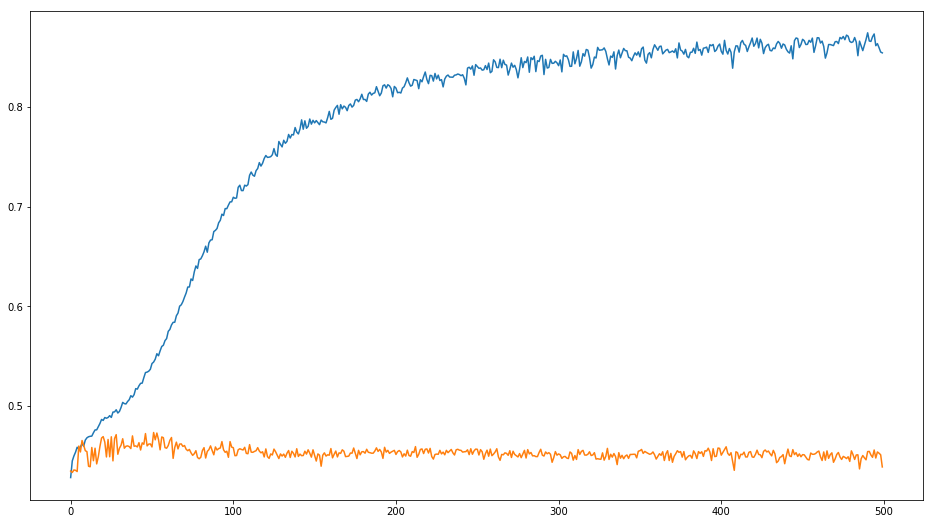

In [243]:
plt.figure(figsize=(16, 9))
plt.plot(plot_train)
plt.plot(plot_val)
plt.show()

In [ ]:
from tensorflow.keras.callbacks import Callback

class NBatchLogger(Callback):
    def __init__(self, display):
        self.seen = 0
        self.display = display

    def on_batch_end(self, batch, logs={}):
        self.seen += logs.get('size', 0)
        if self.seen % self.display == 0:
            # you can access loss, accuracy in self.params['metrics']
            print('\n{}/{} - loss ....\n'.format(self.seen, self.params['metrics'])) 

In [ ]:
out_batch = NBatchLogger(display=100)
model.fit(WC_train, Y_train, batch_size=100, validation_data=(WC_test, Y_test), callbacks=[out_batch])